## Construcción de modelos

In [89]:
import pandas as pd
from catboost import CatBoostRegressor
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
import numpy as np
from sklearn.metrics import (mean_absolute_error, r2_score,
                             root_mean_squared_error,
                             mean_absolute_percentage_error, mean_squared_error)

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint

import sys

from xgboost import XGBRegressor

sys.path.append('src')
from feature_engineering.name_splitter import NameSplitter
from feature_engineering.owner_mapper import OwnerMapper
from feature_engineering.seat_rounder import SeatRounder
from feature_engineering.max_power_converter import MaxPowerConverter
from feature_engineering.engine_converter import EngineConverter
from feature_engineering.multiple_interative_imputer import MultipleIterativeImputer
from feature_engineering.multiple_one_hot_encoder import MultipleOneHotEncoder
from feature_engineering.torque_standardizer import TorqueStandardizer
from feature_engineering.mileage_converter import MileageConverter
from feature_engineering.model_dropper import ModelDropper

-------------------
#### Data Processing

-------------------

Apalancados en la ingeniería de features, creamos un conjunto de clases a utilizar en la definición de pipelines, que nos permitan reproducir y modificar con facilidad los pasos de preprocesamiento, previos al entrenamiento de un modelo: 

In [28]:
categorical_cols = ['fuel', 'seller_type', 'transmission', 'make']

preprocess_pipeline = Pipeline(steps=[
    ('name_spliter', NameSplitter()),
    ('mileage_converter', MileageConverter()),
    ('engine_converter', EngineConverter()),
    ('max_power_converter', MaxPowerConverter()),
    ('torque_standardizer', TorqueStandardizer()),
    ('map_owner', OwnerMapper()),
    ('model_dropper', ModelDropper()),
    ('multiple_one_hot_encoder', MultipleOneHotEncoder(categorical_cols=categorical_cols)),
])

columns_to_drop_for_imputation = []

full_pipeline = Pipeline(steps=[
    ('multiple_iterative_imputer', MultipleIterativeImputer(columns_to_drop=columns_to_drop_for_imputation)),
    ('round_seats', SeatRounder()),
])

final_pipeline = Pipeline(steps=[
    ('preprocess_pipeline', preprocess_pipeline),
    ('full_pipeline', full_pipeline),
])

final_pipeline_with_scaler = Pipeline(steps=[
    ('final_pipeline', final_pipeline),
    ('scaler', StandardScaler())
])

In [29]:
data = pd.read_csv('../datasets/Car details v3.csv')
X = data.drop('selling_price', axis=1)
y = data['selling_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [30]:
X_train_processed = final_pipeline.fit_transform(X_train)

In [25]:
missing_values = X_train_processed.isnull().sum()

for column, missing in missing_values.items():
    print(f"Feature: {column} - Missing values: {missing}")

X_train_processed

Feature: year - Missing values: 0
Feature: km_driven - Missing values: 0
Feature: owner - Missing values: 0
Feature: seats - Missing values: 0
Feature: mileage_kmpl - Missing values: 0
Feature: engine_cc - Missing values: 0
Feature: max_power_bhp - Missing values: 0
Feature: torque_peak_power - Missing values: 0
Feature: torque_peak_speed - Missing values: 0
Feature: fuel_Diesel - Missing values: 0
Feature: fuel_LPG - Missing values: 0
Feature: fuel_Petrol - Missing values: 0
Feature: seller_type_Individual - Missing values: 0
Feature: seller_type_Trustmark Dealer - Missing values: 0
Feature: transmission_Manual - Missing values: 0
Feature: make_Audi - Missing values: 0
Feature: make_BMW - Missing values: 0
Feature: make_Chevrolet - Missing values: 0
Feature: make_Daewoo - Missing values: 0
Feature: make_Datsun - Missing values: 0
Feature: make_Fiat - Missing values: 0
Feature: make_Force - Missing values: 0
Feature: make_Ford - Missing values: 0
Feature: make_Honda - Missing values: 0

,year,km_driven,owner,seats,mileage_kmpl,engine_cc,max_power_bhp,torque_peak_power,torque_peak_speed,fuel_Diesel,...,make_Mercedes-Benz,make_Mitsubishi,make_Nissan,make_Opel,make_Renault,make_Skoda,make_Tata,make_Toyota,make_Volkswagen,make_Volvo
6783,2006,120000,3,5,19.70,796.0,46.30,62.0,3000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1073,2018,100000,1,7,12.90,2755.0,174.50,450.0,2400.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7756,2017,39000,1,5,19.59,1995.0,187.74,380.0,2750.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144,2013,39000,1,5,14.28,1798.0,138.03,173.0,4000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6424,2013,70000,2,5,23.40,1248.0,74.00,190.0,2000.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,2009,120000,1,7,12.05,2179.0,120.00,290.0,2800.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5390,2014,80000,2,5,23.40,1248.0,74.00,190.0,2000.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
860,2016,35000,1,5,18.60,1197.0,81.83,114.7,4000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7603,2019,27000,1,5,28.40,1248.0,74.02,190.0,2000.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
X_test_processed = final_pipeline.transform(X_test)

# Mostrar las primeras filas de X_test
print("Test data processed head:")
X_test_processed

Test data processed head:


/Users/christianpisani/Learning/Posgrado/venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,year,km_driven,owner,seats,mileage_kmpl,engine_cc,max_power_bhp,torque_peak_power,torque_peak_speed,fuel_Diesel,...,make_Mercedes-Benz,make_Mitsubishi,make_Nissan,make_Opel,make_Renault,make_Skoda,make_Tata,make_Toyota,make_Volkswagen,make_Volvo
1971,2004,110000,3,5,12.800000,1493.000000,100.000000,128.511000,4600.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4664,2014,291977,1,7,14.000000,2179.000000,138.100000,320.000000,2700.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5448,2016,70000,1,5,23.200000,1248.000000,73.940000,190.000000,2000.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3333,2006,120000,2,5,16.900000,1497.000000,100.000000,132.435000,4800.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2316,2013,69000,2,5,22.900000,1248.000000,74.000000,190.000000,2000.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,2015,35000,1,5,18.600000,1197.000000,81.830000,114.700000,4000.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1956,2011,90000,3,6,19.658376,1901.557735,96.774239,195.341145,2658.226378,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3782,2017,20000,1,8,11.960000,1298.000000,80.000000,103.000000,4500.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
799,2018,60000,1,5,23.010000,999.000000,67.000000,91.000000,4250.000000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


A continuación crearemos diversos modelos para luego compararlos.

-------------------
#### Ridge

-------------------

In [46]:
model = Ridge()

ridge = GridSearchCV(
    model,
    {"alpha": np.linspace(0, 20, 1000)},
    refit=True,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_mean_absolute_error'
)

ridge.fit(X_train_processed, y_train_log)

y_pred_ridge_log = ridge.predict(X_test_processed)
y_pred_ridge = np.expm1(y_pred_ridge_log)

metrics_ridge = {
    "name": "Ridge",
    "MAE_training": mean_absolute_error(y_train_log, ridge.predict(X_train_processed)),
    "MAE": mean_absolute_error(y_test, y_pred_ridge),
    "RMSE": root_mean_squared_error(y_test, y_pred_ridge),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred_ridge),
    "R2": r2_score(y_test, y_pred_ridge)
}

-------------------
#### Random Forest

-------------------

In [51]:
model = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

random_forest = RandomizedSearchCV(
    estimator=model,
    n_iter=50,
    param_distributions=param_dist,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_mean_squared_error'
)

random_forest.fit(X_train_processed, y_train_log)

y_pred_random_forest_log = random_forest.predict(X_test_processed)
y_pred_random_forest = np.expm1(y_pred_random_forest_log)

metrics_rf = {
    "name": "Random Forest",
    "MAE_training": mean_absolute_error(y_train_log, random_forest.predict(X_train_processed)),
    "MAE": mean_absolute_error(y_test, y_pred_random_forest),
    "RMSE": root_mean_squared_error(y_test, y_pred_random_forest),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred_random_forest),
    "R2": r2_score(y_test, y_pred_random_forest)
}

-------------------
#### CatBoost

-------------------

In [33]:
model = CatBoostRegressor(
    eval_metric='RMSE',
    random_seed=42,
    verbose=0
)

params = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0, 0.5, 1]
}

catboost = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1,
    random_state=42
)

catboost.fit(X_train_processed, y_train_log)

y_pred_catboost_log = catboost.predict(X_test_processed)
y_pred_catboost = np.expm1(y_pred_catboost_log)

metrics_catboost = {
    "name": "CatBoost",
    "MAE_training": mean_absolute_error(y_train_log, catboost.predict(X_train_processed)),
    "MAE": mean_absolute_error(y_test, y_pred_catboost),
    "RMSE": root_mean_squared_error(y_test, y_pred_catboost),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred_catboost),
    "R2": r2_score(y_test, y_pred_catboost)
}

Fitting 5 folds for each of 50 candidates, totalling 250 fits


-------------------
#### XGBoost

-------------------

In [56]:
model = XGBRegressor(random_state=42)

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(1, 2)
}

xgb = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train_processed, y_train_log)

y_pred_xgb_log = xgb.predict(X_test_processed)
y_pred_xgb = np.expm1(y_pred_xgb_log)

metrics_xgb = {
    "name": "XGBoost",
    "MAE_training": mean_absolute_error(y_train_log, xgb.predict(X_train_processed)),
    "MAE": mean_absolute_error(y_test, y_pred_xgb),
    "RMSE": root_mean_squared_error(y_test, y_pred_xgb),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred_xgb),
    "R2": r2_score(y_test, y_pred_xgb)
}

-------------------
#### Models Comparison

-------------------

In [58]:
metrics = pd.DataFrame([metrics_catboost, metrics_ridge, metrics_rf, metrics_xgb],)
metrics.sort_values(by=['MAE'], ascending=True)

,name,MAE_training,MAE,RMSE,MAPE,R2
2,Random Forest,0.089313,72410.855085,189948.696535,0.146165,0.947623
0,CatBoost,0.110480,72456.798119,196836.741434,0.142167,0.943755
3,XGBoost,0.111187,74215.911151,209015.259299,0.143466,0.936580
1,Ridge,0.191193,111784.408932,262567.855906,0.196235,0.899919


En principio Random Forest parecería ser el modelo con mejor rendimiento. No solo por el bajo MAE sino también por el alto R2, el cuál indica que ajusta y generaliza bastante.

Si bien todos los modelos rinden de forma similar, Ridge presenta el peor desempeño. Esto se puede explicar por su naturaleza lineal, como mencionamos anteriormente, aunque el dataset tenga dimensiones con alta correlación entre ellas también tiene interacciones complejas que creemos Ridge no está logrando capturar adecuadamente.

Creemos, entonces, qué es lógico que aquellos modelos basados en árboles tengan mejor rendimiento que los modelos lineales. El proceso de cotizar un auto no siempre es lineal y depende de muchos factores con relaciones intrincadas. 

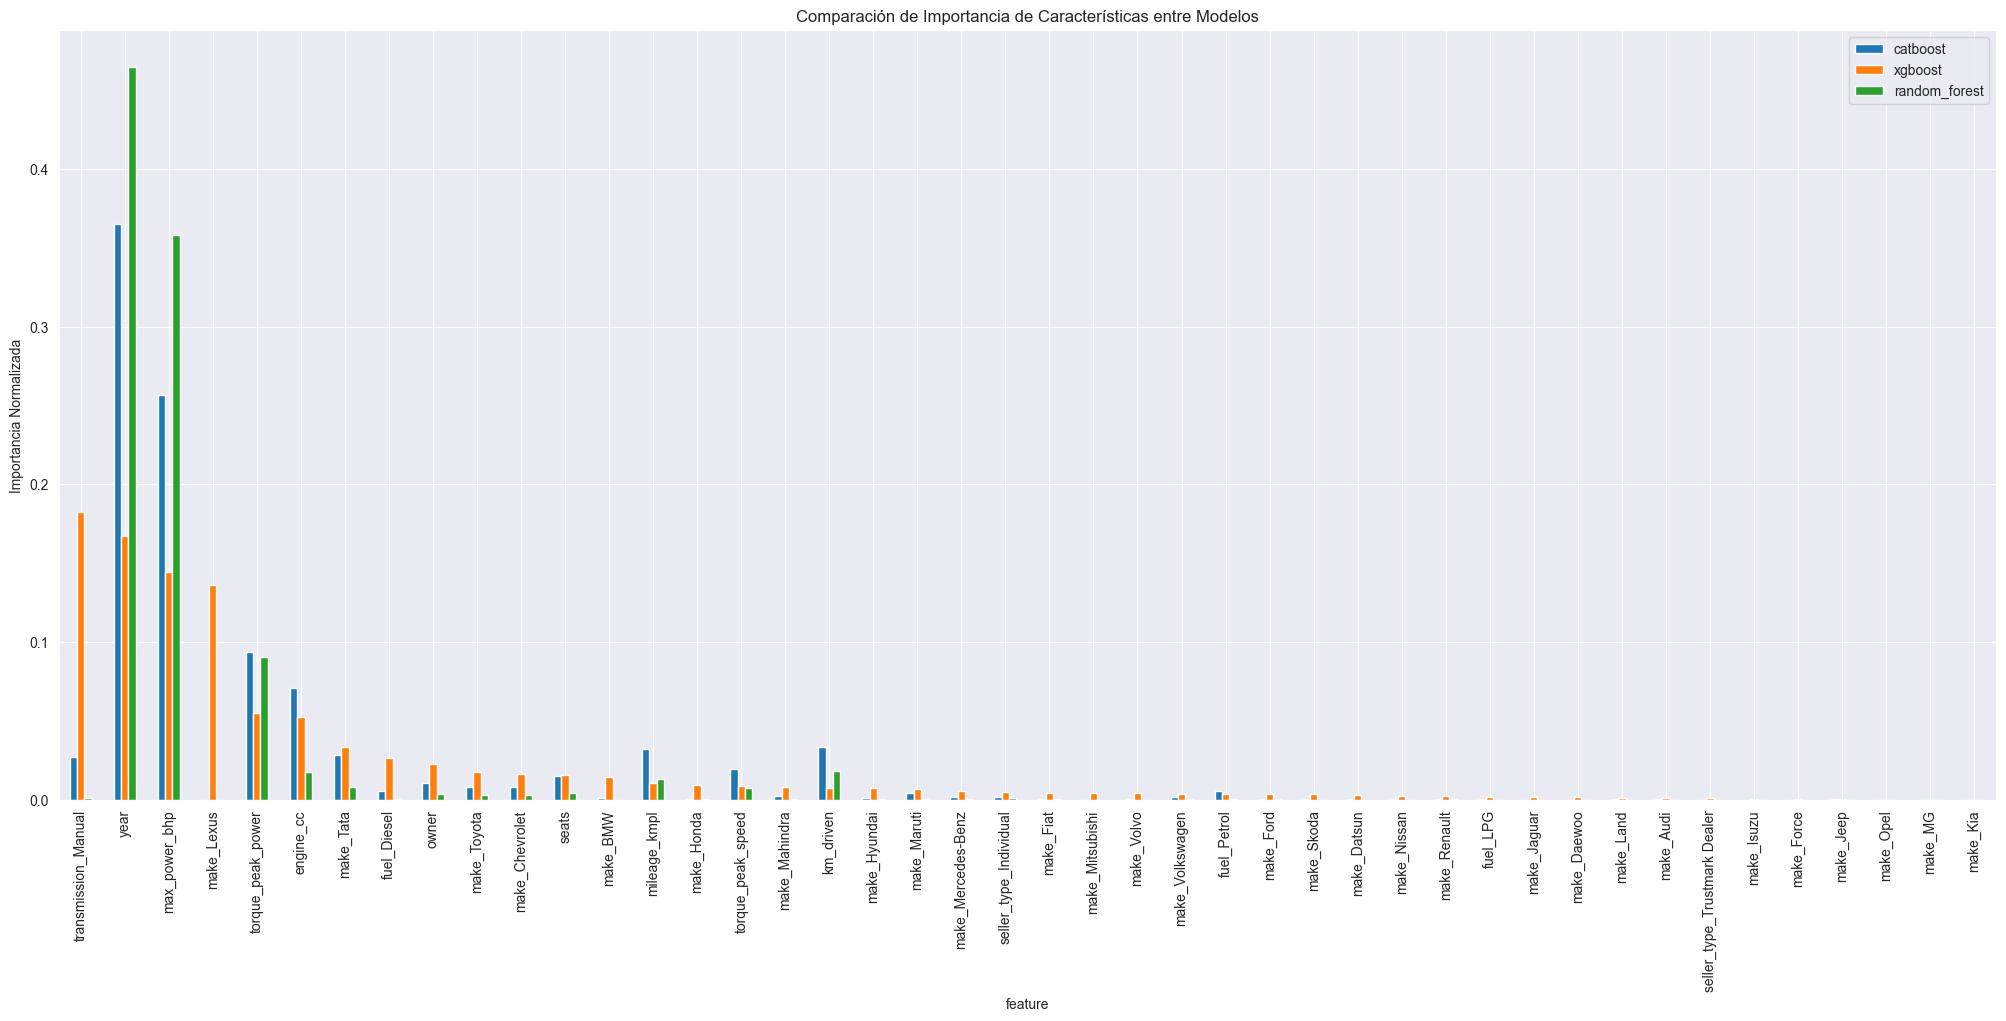

In [102]:
catboost_best = catboost.best_estimator_
xgboost_best = xgb.best_estimator_
rf_best = random_forest.best_estimator_

catboost_importances = catboost_best.get_feature_importance()
xgboost_importances = xgboost_best.feature_importances_
rf_importances = rf_best.feature_importances_

features = X_train_processed.columns
importance_df = pd.DataFrame({
    'feature': features,
    'catboost': catboost_importances,
    'xgboost': xgboost_importances,
    'random_forest': rf_importances
})

importance_df['catboost'] /= importance_df['catboost'].sum()
importance_df['xgboost'] /= importance_df['xgboost'].sum()
importance_df['random_forest'] /= importance_df['random_forest'].sum()

importance_df = importance_df.sort_values(by='xgboost', ascending=False)

importance_df.plot(x='feature', kind='bar', figsize=(25, 10),
                   title="Comparación de Importancia de Características entre Modelos")
plt.xticks(rotation=90)
plt.ylabel("Importancia Normalizada")
plt.show()


Este gráfico muestra para cada modelo, excepto ridge, las dimensiones mejor valuadas (seguramente las de los nodos superioriores). 

Es interesante como CatBoost y Random Forest no solo coinciden en varias sino también priorizan mucho el año y la fuerza del motor, dejando otras propiedades con menos peso. 

XGBoost además de distribuir los pesos de cada dimensión de forma más equilibrada tiene preferencia por algunas que no fueron consideradas por los modelos anteriores como si el auto tiene caja de cambios manual o si la marca es "Lexus". La última tiene sentido ya que es una marca perteneciente a Toyota dedicada a producir autos de lujo ([articulo de wikipedia](https://es.wikipedia.org/wiki/Lexus] articulo)) por lo tanto debe influir mucho en el precio del vehiculo

           Model           MSE
0          Ridge  6.894188e+10
1  Random Forest  3.608051e+10
2        XGBoost  4.368738e+10
3       CatBoost  3.874470e+10


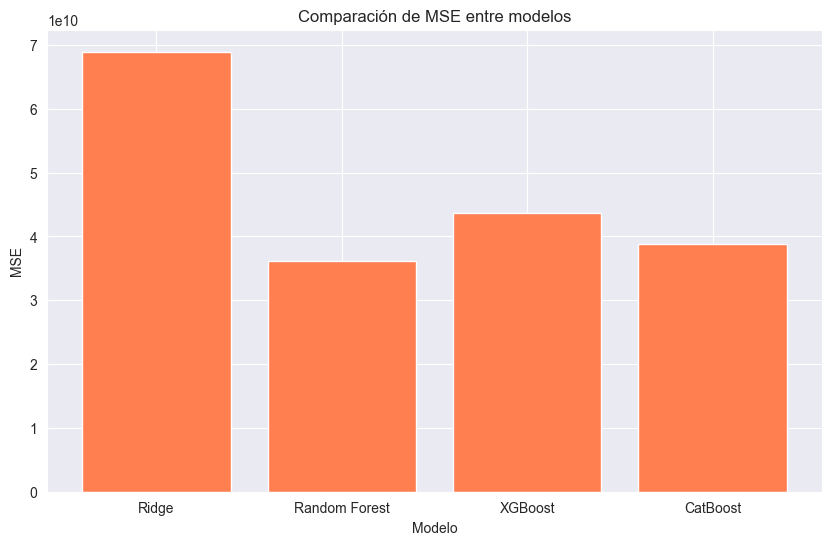

In [71]:
models = {
    'Ridge': ridge,
    'Random Forest': random_forest,
    'XGBoost': xgb,
    'CatBoost': catboost
}

mse_comparison = pd.DataFrame(
    [(name, mean_squared_error(y_test, np.expm1(model.predict(X_test_processed)))) for name, model in models.items()],
    columns=['Model', 'MSE']
)


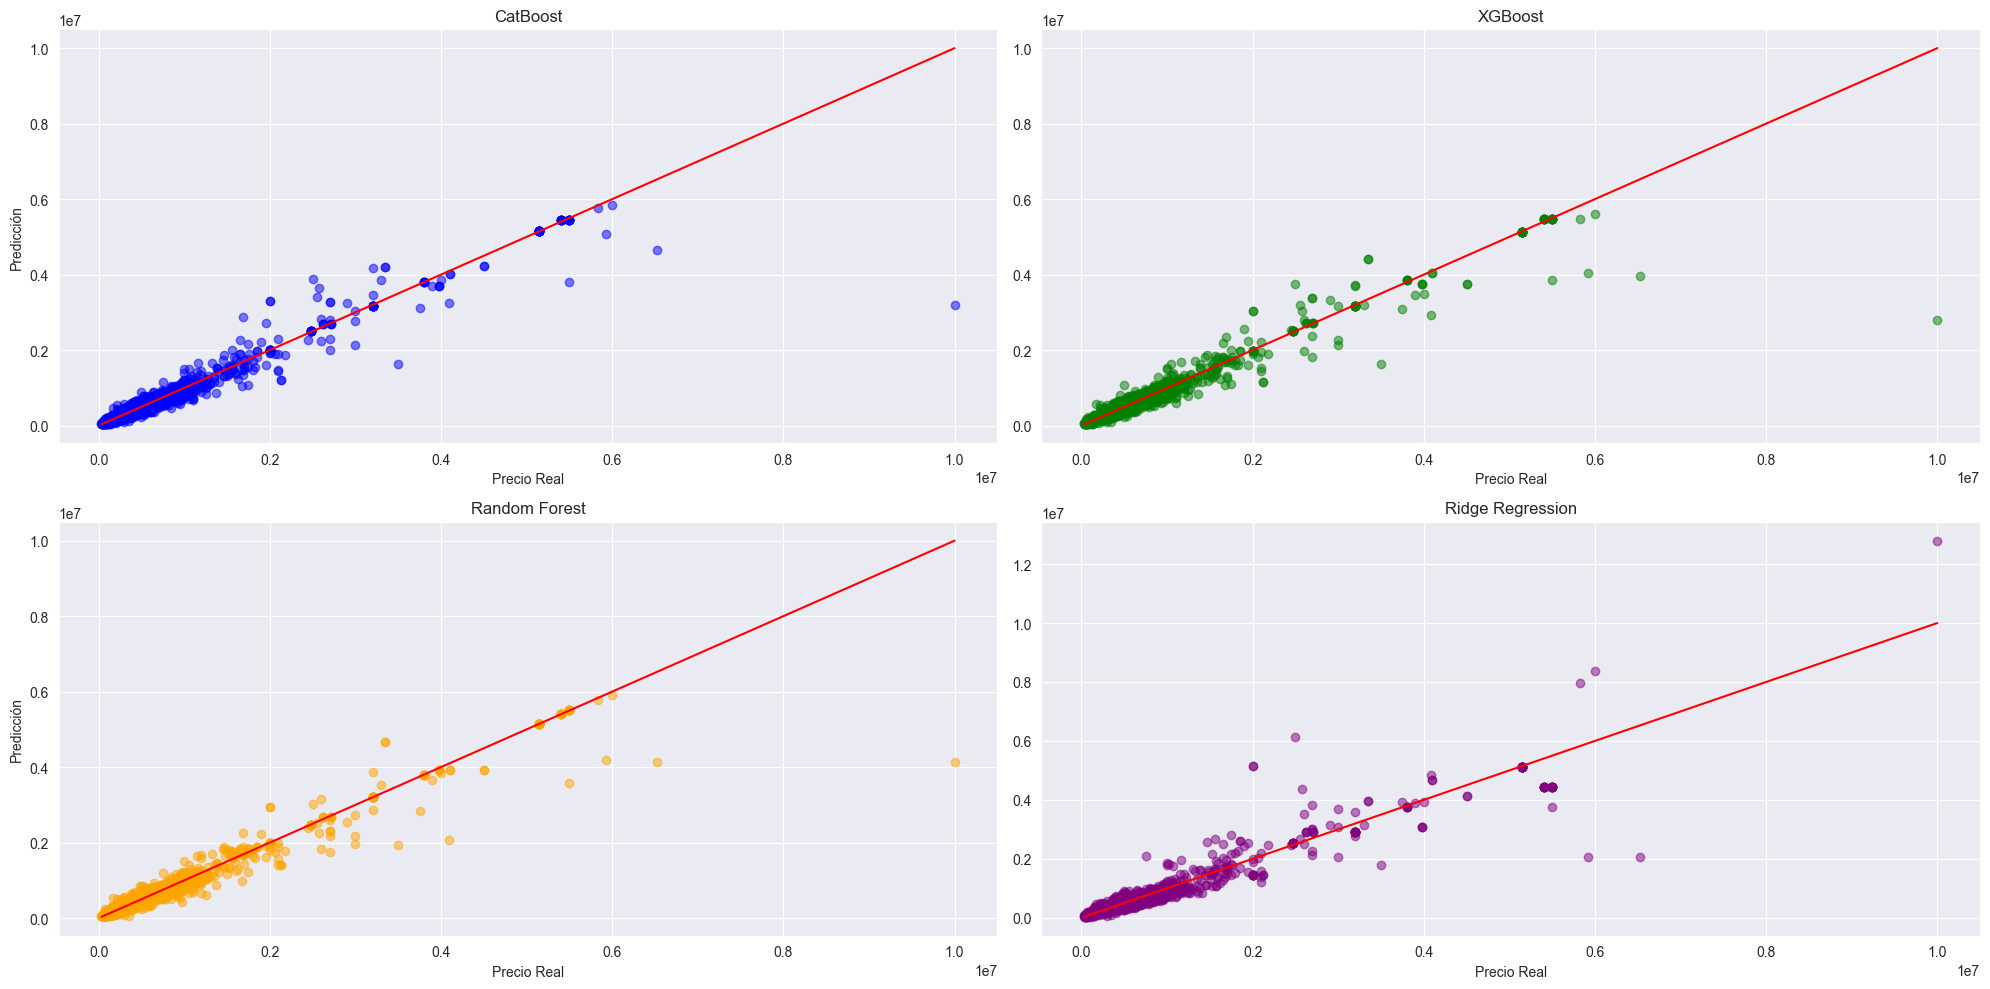

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

# Gráfico 1: CatBoost
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_catboost, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.title("CatBoost")
plt.xlabel("Precio Real")
plt.ylabel("Predicción")

# Gráfico 2: XGBoost
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='green')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.title("XGBoost")
plt.xlabel("Precio Real")

# Gráfico 3: Random Forest
plt.subplot(2, 2, 3)
plt.scatter(y_test, y_pred_random_forest, alpha=0.5, color='orange')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.title("Random Forest")
plt.xlabel("Precio Real")
plt.ylabel("Predicción")

# Gráfico 4: Ridge
plt.subplot(2, 2, 4)
plt.scatter(y_test, y_pred_ridge, alpha=0.5, color='purple')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.title("Ridge Regression")
plt.xlabel("Precio Real")

# Ajustar diseño para evitar superposición
plt.tight_layout()

# Mostrar gráficos
plt.show()


Los gráficos que vemos muestran que tan precisas son las predicciones de los modelos, la línea roja es una recta que identifica el lugar donde la predicción fue perfecta. 

Se puede ver a simple vista que todos los modelos (excepto ridge) tienden a subestimar el valor de los autos cuanto más alto es el precio de los mismos. En los gráficos se observa en la zona inferior derecha de cada uno. 

Ridge en cambio tiene una tendencia a subestimar y sobreestimar por igual.

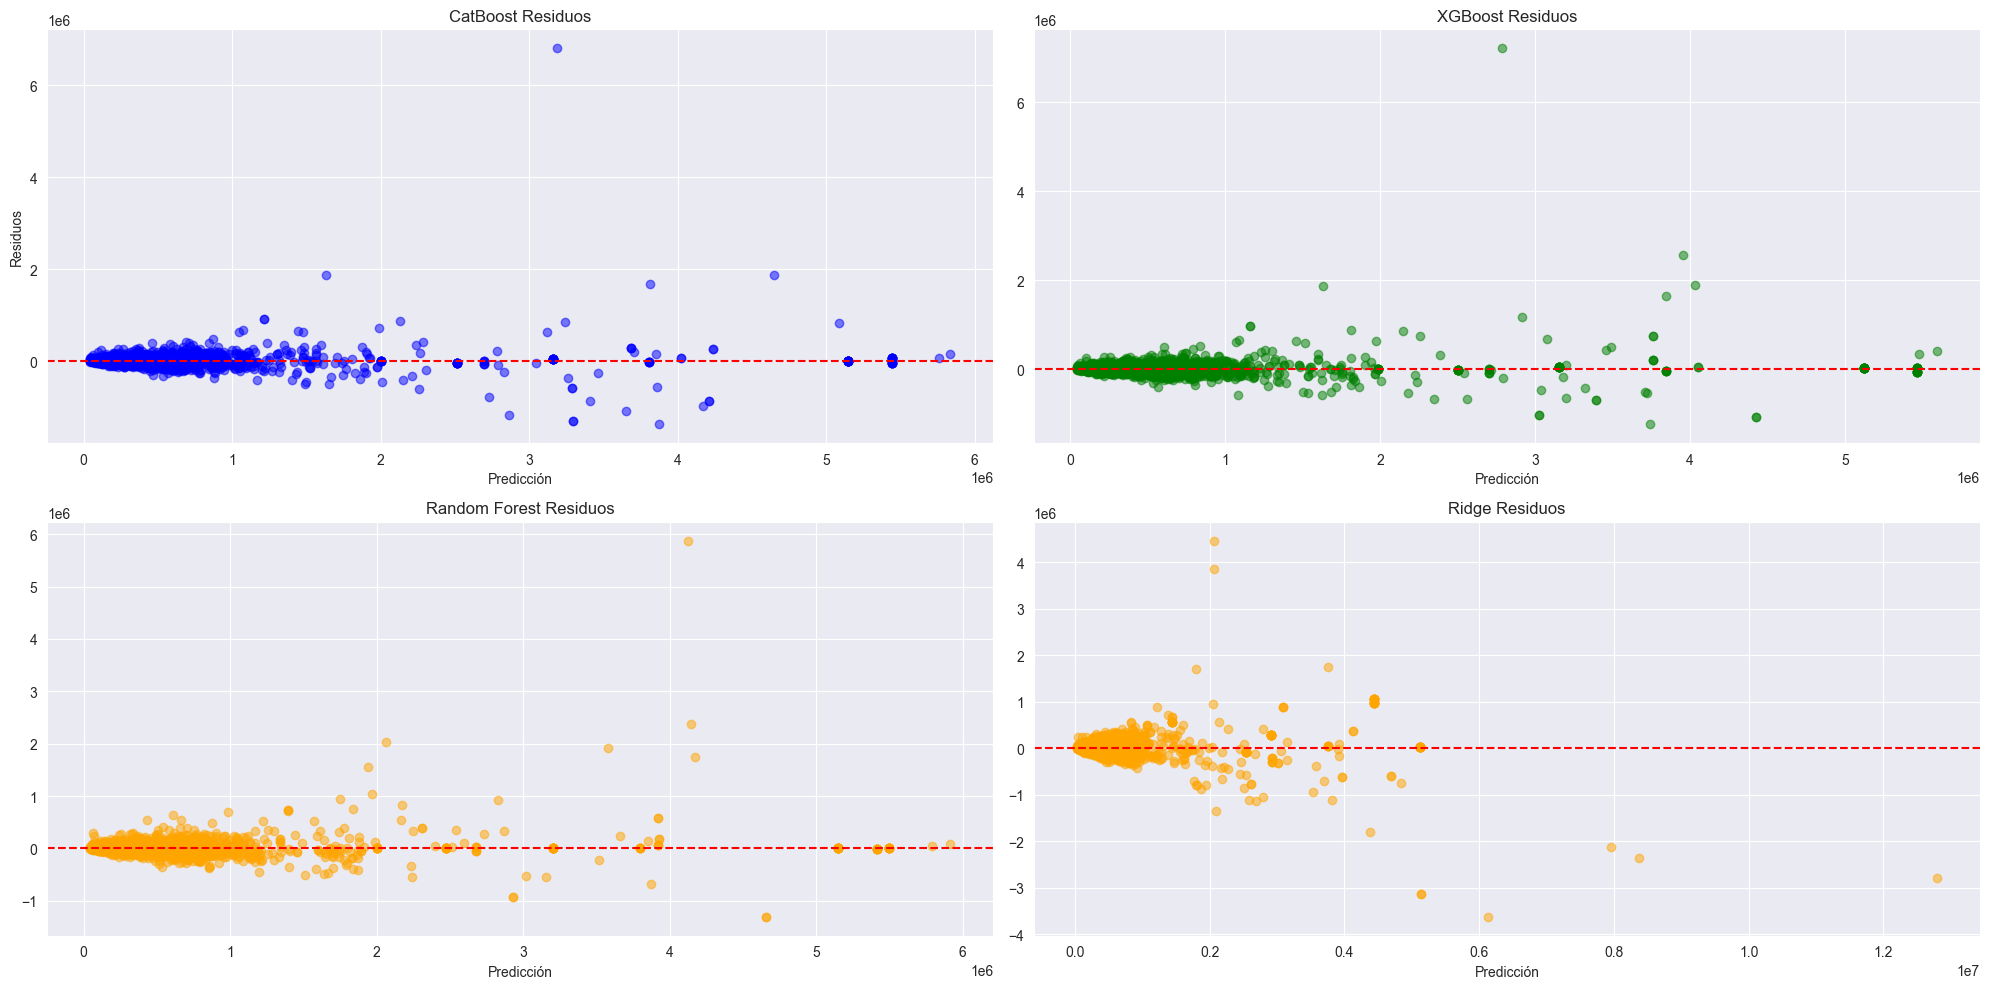

In [105]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
residuals_catboost = y_test - y_pred_catboost
plt.scatter(y_pred_catboost, residuals_catboost, alpha=0.5, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("CatBoost Residuos")
plt.xlabel("Predicción")
plt.ylabel("Residuos")

plt.subplot(2, 2, 2)
residuals_xgboost = y_test - y_pred_xgb
plt.scatter(y_pred_xgb, residuals_xgboost, alpha=0.5, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("XGBoost Residuos")
plt.xlabel("Predicción")

plt.subplot(2, 2, 3)
residuals_rf = y_test - y_pred_random_forest
plt.scatter(y_pred_random_forest, residuals_rf, alpha=0.5, color='orange')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Random Forest Residuos")
plt.xlabel("Predicción")

plt.subplot(2, 2, 4)
residuals_rf = y_test - y_pred_ridge
plt.scatter(y_pred_ridge, residuals_rf, alpha=0.5, color='orange')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Ridge Residuos")
plt.xlabel("Predicción")
plt.tight_layout()

plt.show()


Este gráfico muestra los residuos (diferencia entre los valores reales y los predichos) en función de las predicciones para los cuatro modelos. Así podemos observar qué tan bien los modelos están ajustando los datos en diferentes rangos de predicción.

- A todos los modelos les cuesta predecir a medida que los precios suben. Confirmando lo analizado en los gráficos anteriores.
- CatBoost y XGBoost tienen distribuciones similares, uniformes y cercanas a cero.
- Random Forest logra predecir muy bien valores bajos pero a medida que los valores crecen se dispersa mucho más que XGBoost y CatBoost
- Ridge tiene la peor distribución de residuos, lo que confirma que no es adecuado para este tipo de problema con relaciones complejas y no lineales.